In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2


In [7]:
def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Changes: Set the random seed for reproducibity
  np.random.seed(10 + m) # adding 'm' to vary seed in each iteration   **** SEED ranging from 10 until 10 009 (10 010 upper bound excluded)
    # *** firstly, this allows us to include the random seed within the function to ensure reproducibility and ensure that 
    # *** the function can never be called without a seed being determined/set.
    # *** secondly, this allows us to vary the seed for each iteration in the upcoming for loop where the func is 
    # *** called so that we get different simulated results for each iteration of the for loop (list comprehension).
    # *** the seed is varied such that it is always 10 more than m, so we never have 2 instances of the 
    # *** seed (a replicated seed) within a given for loop. Each iteration is a unique random simulation based on the function.

  # Create DataFrame for people at events with initial infection and traced status
  n_weddings = 200
  n_brunches = 800
 
  events = ['wedding'] * n_weddings + ['brunch'] * n_brunches
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': False  # Initially setting traced status as FALSE   # ***
  })

  # Explicitly set 'traced' column to nullable boolean type
  ##ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())   # ***

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces


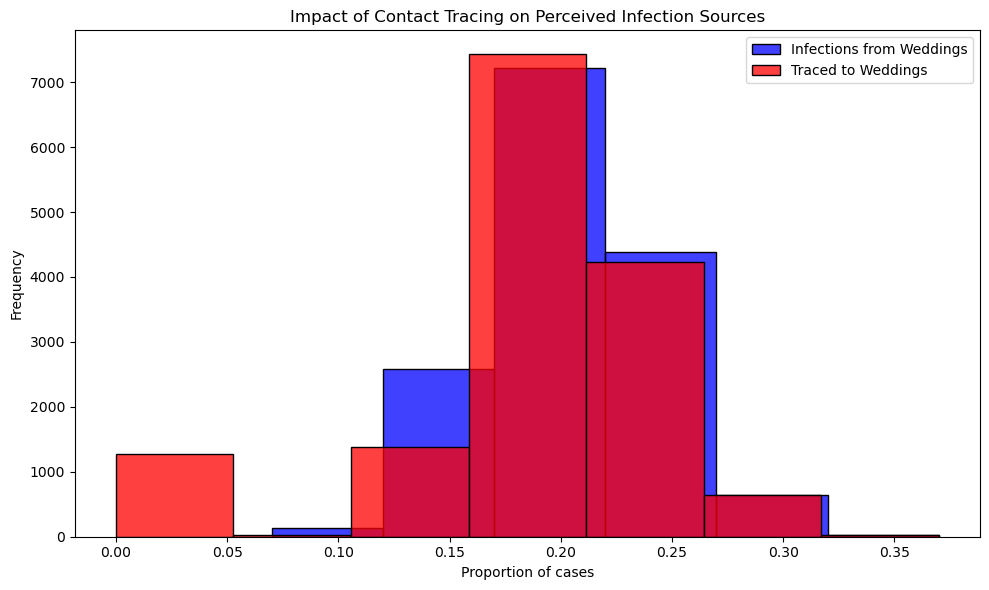

In [8]:
# Set the random seed for reproducibility
#np.random.seed(10) # **** not necessary

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(15000)]   # **** 15 000 simulations
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()
